# Generic scikit-learn classifier

run any scikit-learn compatible classifier or list of classifiers
### **Function steps** :
> **Generate a scikit-learn model configuration** using the `model_pkg_class` parameter
>   * input a package and class name, for example, `sklearn.linear_model.LogisticRegression`  
>   * mlrun will find the class and instantiate a copy using default parameters  
>   * You can modify both the model class instantiator and the fit methods  (other functions could be similarly modified)

> **Get a sample of data** from a data source
>  * select all rows using -1
>  * select a random sample of rows using a negative integer
>  * select consecutive rows using a positive integer

> **Split the data** into train, validation, and test sets 
>  * the test set is saved as an artifact and never seen again until testing
>  * WIP: this will be parametrized to produce cross-validator splits (one way of performing CV)

> **Train the model** using xgboost in one of its flavours (dask, gpu, mpi...)

> **Pickle / serialize the model**
>  * models can be pickled or saved as json (a newer xgboost format)

> **Evaluate the model**
>  * a custom evaluator can be provided, see function doc for details

### **Example steps**

1. [Data exploration](#Data-exploration)
2. [Importing the function](#Importing-the-function)
3. [Setup sklearn trainer parameters](#Setup-sklearn-trainer-parameters)
4. [Set model parameters and run locally](#Set-model-parameters-and-run-locally)
5. [Set model parameters and run remotely](#Set-model-parameters-and-run-remotely)

### **Data exploration**

In [1]:
# Dataset is generated from sklearn's load_iris
from sklearn.datasets import load_iris

data = load_iris()
print(data['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [2]:
import pandas as pd

data_url = 'https://s3.wasabisys.com/iguazio/data/function-marketplace-data/sklearn_classifier/iris_dataset.csv'
df = pd.read_csv(data_url)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### **Importing the function**

In [3]:
import mlrun
import os

mlrun.set_environment(project='function-marketplace')

# Importing the function from the hub
fn = mlrun.import_function("hub://sklearn_classifier")

fn.apply(mlrun.auto_mount())
if os.getenv('MLRUN_CE','false')=='true':
    fn.spec.disable_auto_mount=False

> 2022-11-17 14:05:16,289 [warning] Failed syncing config from server: {'exc': "'bool' object has no attribute 'mode'", 'traceback': 'Traceback (most recent call last):\n  File "/opt/conda/lib/python3.8/site-packages/mlrun/db/httpdb.py", line 262, in connect\n    if config.ce.mode and config.ce.mode != server_cfg.get("ce_mode", ""):\nAttributeError: \'bool\' object has no attribute \'mode\'\n'}
> 2022-11-17 14:05:16,307 [info] loaded project function-marketplace from MLRun DB


### **Setup sklearn trainer parameters**

the following task paramaters are common to all runs

In [4]:
task_params = {
    #"name" : "sklearn classifier",
    "params" : {
        "sample"             : -1,
        "test_size"          : 0.30,
        "train_val_split"    : 0.70,
        "random_state"       : 1,
        "n_jobs"             : -1,
        "plots_dest"         : "plots-p",
        "models_dest"        : 'sklearn-clfmodel'}}

models = [
    "sklearn.ensemble.RandomForestClassifier", 
    "sklearn.linear_model.LogisticRegression",
    "sklearn.ensemble.AdaBoostClassifier"
]

### **Set model parameters and run locally**

* loop over a list of candidate models, update the task and run a local trainer for that model  
* optionally customize some parameters for each model
* accumulate the resulting artifacts in a list of dicts for debugging and testing purposes  

please note that the following parameters have been chosen without regard to optimization and model tuning

> 2022-11-17 14:05:16,525 [info] starting run sklearn_ensemble_RandomForestClassifier uid=a0890b2aa1a041c8bf4b6a48bc02b2f9 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
function-marketplace,...bc02b2f9,0,Nov 17 14:05:16,completed,sklearn_ensemble_RandomForestClassifier,kind=owner=jovyanhost=mlrun-jupyter-5fccd98548-vqhwqclass=sklearn.ensemble.RandomForestClassifier,dataset,model_pkg_class=sklearn.ensemble.RandomForestClassifierlabel_column=labelCLASS_max_depth=5,accuracy=0.90625test-error=0.09375auc-micro=0.99365234375auc-weighted=0.9970043572984749f1-score=0.886039886039886precision_score=0.875recall_score=0.9333333333333332,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodel


> 2022-11-17 14:05:18,712 [info] run executed, status=completed
> 2022-11-17 14:05:18,714 [info] starting run sklearn_linear_model_LogisticRegression uid=3e5174af9a444d01994fccbfaee8144b DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
function-marketplace,...aee8144b,0,Nov 17 14:05:18,completed,sklearn_linear_model_LogisticRegression,kind=owner=jovyanhost=mlrun-jupyter-5fccd98548-vqhwqclass=sklearn.linear_model.LogisticRegression,dataset,model_pkg_class=sklearn.linear_model.LogisticRegressionlabel_column=labelCLASS_solver=liblinear,accuracy=0.875test-error=0.125auc-micro=0.97265625auc-weighted=0.997004357298475f1-score=0.8534798534798534precision_score=0.8518518518518517recall_score=0.9111111111111111,test_setconfusion-matrixprecision-recall-multiclassroc-multiclassmodel


> 2022-11-17 14:05:19,889 [info] run executed, status=completed
> 2022-11-17 14:05:19,891 [info] starting run sklearn_ensemble_AdaBoostClassifier uid=d36a202888a348849d03346de4fc0e30 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
function-marketplace,...e4fc0e30,0,Nov 17 14:05:19,completed,sklearn_ensemble_AdaBoostClassifier,kind=owner=jovyanhost=mlrun-jupyter-5fccd98548-vqhwqclass=sklearn.ensemble.AdaBoostClassifier,dataset,model_pkg_class=sklearn.ensemble.AdaBoostClassifierlabel_column=labelCLASS_n_estimators=200CLASS_learning_rate=0.01,accuracy=0.90625test-error=0.09375auc-micro=0.96044921875auc-weighted=1.0f1-score=0.886039886039886precision_score=0.875recall_score=0.9333333333333332,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodel


> 2022-11-17 14:05:21,523 [info] run executed, status=completed


<Figure size 432x288 with 0 Axes>

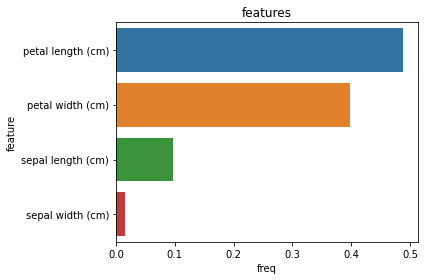

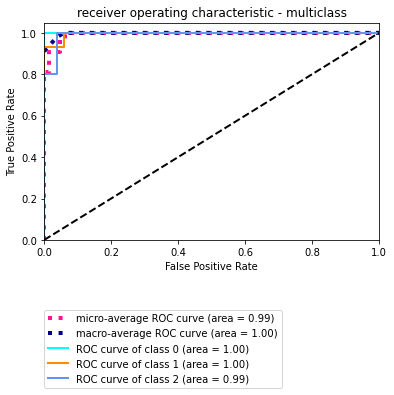

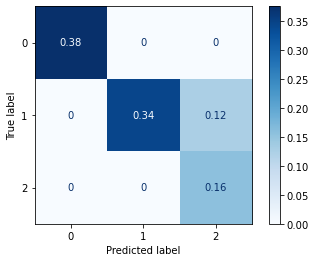

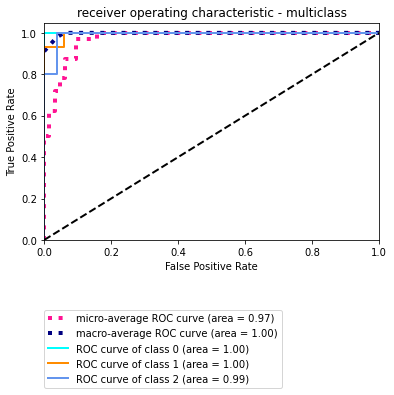

<Figure size 432x288 with 0 Axes>

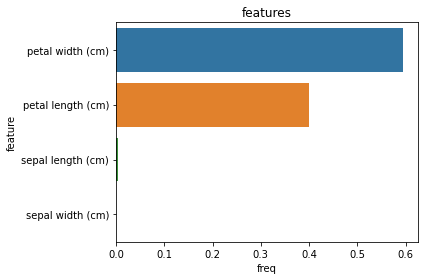

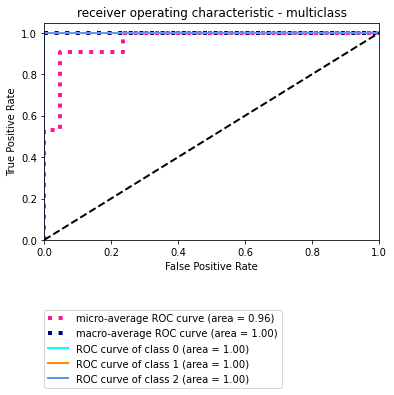

In [5]:
outputs = []
for model in models:
    task_copy = task_params.copy()
    task_copy.update(
        {
            "params":{ "model_pkg_class" : model,
                       "label_column"    : "label"}
        }
    )
    
    # customize specific model parameters
    if "RandomForestClassifier" in model:
        task_copy["params"].update({"CLASS_max_depth" : 5})

    if "LogisticRegression" in model:
        task_copy["params"].update({"CLASS_solver" : "liblinear"})
    
    if "AdaBoostClassifier" in model:
        task_copy["params"].update({"CLASS_n_estimators"  : 200,
                                    "CLASS_learning_rate" : 0.01
                                   })
    
    name = model.replace('.', '_')
    output = fn.run(mlrun.new_task(**task_copy),
                    name=name,
                    inputs={"dataset"  : data_url},
                    local=True)
    
    outputs.append({name: output.outputs})


In [6]:
outputs

[{'sklearn_ensemble_RandomForestClassifier': {'accuracy': 0.90625,
   'test-error': 0.09375,
   'auc-micro': 0.99365234375,
   'auc-weighted': 0.9970043572984749,
   'f1-score': 0.886039886039886,
   'precision_score': 0.875,
   'recall_score': 0.9333333333333332,
   'test_set': 'store://artifacts/function-marketplace/sklearn_ensemble_RandomForestClassifier_test_set:a0890b2aa1a041c8bf4b6a48bc02b2f9',
   'confusion-matrix': 's3://marketplace-daniels-12538-0ad28260e042/model/plots/sklearn_ensemble_RandomForestClassifier/0/confusion-matrix.html',
   'feature-importances': 's3://marketplace-daniels-12538-0ad28260e042/model/plots/sklearn_ensemble_RandomForestClassifier/0/feature-importances.html',
   'precision-recall-multiclass': 's3://marketplace-daniels-12538-0ad28260e042/model/plots/sklearn_ensemble_RandomForestClassifier/0/precision-recall-multiclass.html',
   'roc-multiclass': 's3://marketplace-daniels-12538-0ad28260e042/model/plots/sklearn_ensemble_RandomForestClassifier/0/roc-multic

### **Set model parameters and run remotely**

In [7]:
outputs = []
for model in models:
    task_copy = task_params.copy()
    task_copy.update(
        {
            "params":{ "model_pkg_class" : model,
                       "label_column"    : "label"}
        }
    )
    
    # customize specific model parameters
    if "RandomForestClassifier" in model:
        task_copy["params"].update({"CLASS_max_depth" : 5})

    if "LogisticRegression" in model:
        task_copy["params"].update({"CLASS_solver" : "liblinear"})
    
    if "AdaBoostClassifier" in model:
        task_copy["params"].update({"CLASS_n_estimators"  : 200,
                                    "CLASS_learning_rate" : 0.01
                                   })
    
    name = model.replace('.', '_')
    output = fn.run(mlrun.NewTask(**task_copy),
                    name=name,
                    inputs={"dataset"  : data_url},
                    local=False)
    outputs.append({name: output.outputs})

> 2022-11-17 14:05:22,042 [info] starting run sklearn_ensemble_RandomForestClassifier uid=cb820150c16a42518ed1c2bd058aa1c9 DB=http://mlrun-api:8080
> 2022-11-17 14:05:22,247 [info] Job is running in the background, pod: sklearn-ensemble-randomforestclassifier-rgv6v
> 2022-11-17 14:05:28,789 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
function-marketplace,...058aa1c9,0,Nov 17 14:05:25,completed,sklearn_ensemble_RandomForestClassifier,kind=jobowner=jovyanmlrun/client_version=1.1.1host=sklearn-ensemble-randomforestclassifier-rgv6vclass=sklearn.ensemble.RandomForestClassifier,dataset,model_pkg_class=sklearn.ensemble.RandomForestClassifierlabel_column=labelCLASS_max_depth=5,accuracy=0.90625test-error=0.09375auc-micro=0.99169921875auc-weighted=0.9970043572984749f1-score=0.886039886039886precision_score=0.875recall_score=0.9333333333333332,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodel


> 2022-11-17 14:05:31,405 [info] run executed, status=completed
> 2022-11-17 14:05:31,406 [info] starting run sklearn_linear_model_LogisticRegression uid=86d691710f1c4aeca871710c1a39da62 DB=http://mlrun-api:8080
> 2022-11-17 14:05:31,639 [info] Job is running in the background, pod: sklearn-linear-model-logisticregression-mxr6g
> 2022-11-17 14:05:37,596 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
function-marketplace,...1a39da62,0,Nov 17 14:05:34,completed,sklearn_linear_model_LogisticRegression,kind=jobowner=jovyanmlrun/client_version=1.1.1host=sklearn-linear-model-logisticregression-mxr6gclass=sklearn.linear_model.LogisticRegression,dataset,model_pkg_class=sklearn.linear_model.LogisticRegressionlabel_column=labelCLASS_solver=liblinear,accuracy=0.875test-error=0.125auc-micro=0.97265625auc-weighted=0.997004357298475f1-score=0.8534798534798534precision_score=0.8518518518518517recall_score=0.9111111111111111,test_setconfusion-matrixprecision-recall-multiclassroc-multiclassmodel


> 2022-11-17 14:05:37,759 [info] run executed, status=completed
> 2022-11-17 14:05:37,760 [info] starting run sklearn_ensemble_AdaBoostClassifier uid=de9dceb6374145b2b0dcc72170fba052 DB=http://mlrun-api:8080
> 2022-11-17 14:05:38,236 [info] Job is running in the background, pod: sklearn-ensemble-adaboostclassifier-lcssx
> 2022-11-17 14:05:45,405 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
function-marketplace,...70fba052,0,Nov 17 14:05:41,completed,sklearn_ensemble_AdaBoostClassifier,kind=jobowner=jovyanmlrun/client_version=1.1.1host=sklearn-ensemble-adaboostclassifier-lcssxclass=sklearn.ensemble.AdaBoostClassifier,dataset,model_pkg_class=sklearn.ensemble.AdaBoostClassifierlabel_column=labelCLASS_n_estimators=200CLASS_learning_rate=0.01,accuracy=0.90625test-error=0.09375auc-micro=0.96044921875auc-weighted=1.0f1-score=0.886039886039886precision_score=0.875recall_score=0.9333333333333332,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodel


> 2022-11-17 14:05:47,423 [info] run executed, status=completed


[Back to the top](#Generic-scikit-learn-classifier)